In [45]:
%load_ext autoreload
%autoreload 2
import multiprocessing as mp
mp.set_start_method('spawn', force=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import tabulate
from scripts.wandb_experiments.static_texture_benchmark import (
    TexturingGeometryAndPrompts,
)
from text3d2video.util import concat_lists

mando = TexturingGeometryAndPrompts(
    "mv_helmet:latest",
    ["A Mandalorian Helmet in Silver", "Jango Fett Helmet", "Boba Fett Helmet"],
)
cat_statue = TexturingGeometryAndPrompts(
    "cat_statue_mv:latest", ["Metalic Cat Statue", "Cat Statue"]
)
backpack = TexturingGeometryAndPrompts("mv_backpack:latest", ["A 3D Backpack"])
human = TexturingGeometryAndPrompts(
    "human_mv:latest", ["Deadpool", "Stormtrooper", "Abraham Lincoln"]
)
lion = TexturingGeometryAndPrompts(
    "mv_lion:latest", ["A cute 3D cartoon lion with brown hair", "A marble lion"]
)

inputs = [mando, cat_statue, human, backpack, lion]
scenes = concat_lists(s.to_scenes() for s in inputs)
print(tabulate.tabulate([s.tabulate_row() for s in scenes], headers="keys"))

animation_tag         prompt                                    seed
--------------------  --------------------------------------  ------
mv_helmet:latest      A Mandalorian Helmet in Silver               0
mv_helmet:latest      Jango Fett Helmet                            0
mv_helmet:latest      Boba Fett Helmet                             0
cat_statue_mv:latest  Metalic Cat Statue                           0
cat_statue_mv:latest  Cat Statue                                   0
human_mv:latest       Deadpool                                     0
human_mv:latest       Stormtrooper                                 0
human_mv:latest       Abraham Lincoln                              0
mv_backpack:latest    A 3D Backpack                                0
mv_lion:latest        A cute 3D cartoon lion with brown hair       0
mv_lion:latest        A marble lion                                0


In [48]:
from itertools import product
from omegaconf import OmegaConf

from scripts.wandb_experiments.static_texture_benchmark import TexturingMethod
from scripts.wandb_runs.make_texture import MakeTextureConfig
from text3d2video.pipelines.pipeline_utils import ModelConfig
from text3d2video.pipelines.texturing_pipeline import TexturingConfig
from text3d2video.utilities.omegaconf_util import omegaconf_from_dotdict

base = OmegaConf.structured(
    MakeTextureConfig(
        prompt="",
        animation_tag="",
        model=ModelConfig(),
        texgen=TexturingConfig(use_update_masks=False, use_prev_clean_tex=False),
    )
)

sweep_dict = {
    # "texgen.do_text_and_texture_resampling": [True, False],
    # 'texgen.use_reference_kvs': [True, False],
    "texgen.use_update_masks": [True, False],
    "texgen.use_prev_clean_tex": [True, False],
}


keys = list(sweep_dict.keys())
values_product = list(product(*[sweep_dict[k] for k in keys]))

methods = []
for values in values_product:
    overrides = omegaconf_from_dotdict(dict(zip(keys, values)))
    new_cfg = OmegaConf.merge(base, overrides)

    name = "TexGen"
    if overrides.texgen.use_update_masks:
        name += " + UV Update Masks"
    if overrides.texgen.use_prev_clean_tex:
        name += "+ Prev Clean Tex"

    methods.append(TexturingMethod(name=name, base_config=new_cfg))


print(
    tabulate.tabulate(
        [m.tabulate_row(flat_config=True) for m in methods], headers="keys"
    )
)

name                                      base_config
----------------------------------------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
TexGen + UV Update Masks+ Prev Clean Tex  {'prompt': '', 'animation_tag': '', 'model': {'sd_repo': 'runwayml/stable-diffusion-v1-5', 'controlnet_repo': 'lllyasviel/control_v11f1p_sd15_depth'}, 'texgen': {'num_inference_steps': 15, 'guidance_scale': 7.5, 'controlnet_conditioning_scale': 1.0, 'uv_res': 600, 'do_text_and_texture_resampling': True, 'use_update_masks': True, 'use_referecnce_kvs': True, 'use_prev_clean_tex': True}, 'seed': 0, 'texture_out_art': 'texture'}
Te

In [49]:
from scripts.wandb_experiments.static_texture_benchmark import TexturingBenchmarkConfig, texturing_benchmark

config = OmegaConf.create(TexturingBenchmarkConfig(scenes, methods))

spec = texturing_benchmark(config)

In [ ]:
import wandb_util.wandb_util as wbu

wbu.sync_experiment(texturing_benchmark, config, "texutre_benchmark")

Experiment: https://wandb.ai/romeu/diffusion-3D-features/groups/texutre_benchmark/workspace

Would execute 16 new runs:
- TexGen+ Prev Clean Tex
- TexGen
- TexGen
- exp
- TexGen + UV Update Masks
- TexGen
- TexGen
- TexGen + UV Update Masks
- TexGen
- TexGen
- TexGen
- TexGen
- TexGen
- TexGen+ Prev Clean Tex
- TexGen
- TexGen

Would delete 0 outdated runs:

Do you want to continue? (y/n)
Deleting 0 runs
Executing 16 runs


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: romeu. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /home/jorge/thesis/wandb/run-20250514_105223-3sulupzm
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run TexGen+ Prev Clean Tex
wandb: ⭐️ View project at https://wandb.ai/romeu/diffusion-3D-features
wandb: 🚀 View run at https://wandb.ai/romeu/diffusion-3D-features/runs/3sulupzm
wandb:   4 of 4 files downloaded.  
100%|██████████| 15/15 [00:38<00:00,  2.56s/it]


Moviepy - Building video /tmp/tmpo7fd9v_5.mp4.
Moviepy - Writing video /tmp/tmpo7fd9v_5.mp4

Moviepy - Done !
Moviepy - video ready /tmp/tmpo7fd9v_5.mp4


wandb: Adding directory to artifact (/tmp/local_artifacts/rgb_texture/texture)... Done. 0.0s
wandb:                                                                                
wandb: 
wandb: Run summary:
wandb: hash ab822effc0b55ca5e310...
wandb: 
wandb: 🚀 View run TexGen+ Prev Clean Tex at: https://wandb.ai/romeu/diffusion-3D-features/runs/3sulupzm
wandb: ⭐️ View project at: https://wandb.ai/romeu/diffusion-3D-features
wandb: Synced 5 W&B file(s), 0 media file(s), 2 artifact file(s) and 2 other file(s)
wandb: Find logs at: ./wandb/run-20250514_105223-3sulupzm/logs
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: romeu. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /home/jorge/thesis/wandb/run-20250514_105326-wwfuapv9
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run TexGen
wandb: ⭐️ View projec

Moviepy - Building video /tmp/tmpf28to815.mp4.
Moviepy - Writing video /tmp/tmpf28to815.mp4

Moviepy - Done !
Moviepy - video ready /tmp/tmpf28to815.mp4


wandb: Adding directory to artifact (/tmp/local_artifacts/rgb_texture/texture)... Done. 0.0s
wandb:                                                                                
wandb: 
wandb: Run summary:
wandb: hash d459726ba970b7de4d25...
wandb: 
wandb: 🚀 View run TexGen at: https://wandb.ai/romeu/diffusion-3D-features/runs/wwfuapv9
wandb: ⭐️ View project at: https://wandb.ai/romeu/diffusion-3D-features
wandb: Synced 5 W&B file(s), 0 media file(s), 2 artifact file(s) and 2 other file(s)
wandb: Find logs at: ./wandb/run-20250514_105326-wwfuapv9/logs
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: romeu. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /home/jorge/thesis/wandb/run-20250514_105419-braptgm1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run TexGen
wandb: ⭐️ View project at https://wan

Moviepy - Building video /tmp/tmp1i7x7yhp.mp4.
Moviepy - Writing video /tmp/tmp1i7x7yhp.mp4

Moviepy - Done !
Moviepy - video ready /tmp/tmp1i7x7yhp.mp4


wandb: Adding directory to artifact (/tmp/local_artifacts/rgb_texture/texture)... Done. 0.0s
wandb:                                                                                
wandb: 
wandb: Run summary:
wandb: hash 55c56152ed0619efd23a...
wandb: 
wandb: 🚀 View run TexGen at: https://wandb.ai/romeu/diffusion-3D-features/runs/braptgm1
wandb: ⭐️ View project at: https://wandb.ai/romeu/diffusion-3D-features
wandb: Synced 5 W&B file(s), 0 media file(s), 2 artifact file(s) and 2 other file(s)
wandb: Find logs at: ./wandb/run-20250514_105419-braptgm1/logs
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: romeu. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /home/jorge/thesis/wandb/run-20250514_105511-o1rq5r9s
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run exp
wandb: ⭐️ View project at https://wandb.

Moviepy - Building video /tmp/tmpz_z4lgop.mp4.
Moviepy - Writing video /tmp/tmpz_z4lgop.mp4

Moviepy - Done !
Moviepy - video ready /tmp/tmpz_z4lgop.mp4


wandb: Adding directory to artifact (/tmp/local_artifacts/rgb_texture/texture)... Done. 0.0s
wandb:                                                                                
wandb: 
wandb: Run summary:
wandb: hash a328fee1334cb9007983...
wandb: 
wandb: 🚀 View run TexGen + UV Update Masks at: https://wandb.ai/romeu/diffusion-3D-features/runs/nvg5dqmv
wandb: ⭐️ View project at: https://wandb.ai/romeu/diffusion-3D-features
wandb: Synced 5 W&B file(s), 0 media file(s), 2 artifact file(s) and 2 other file(s)
wandb: Find logs at: ./wandb/run-20250514_105520-nvg5dqmv/logs
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: romeu. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /home/jorge/thesis/wandb/run-20250514_105623-38lsmku9
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run TexGen
wandb: ⭐️ View proj

Moviepy - Building video /tmp/tmp6nv5y0z8.mp4.
Moviepy - Writing video /tmp/tmp6nv5y0z8.mp4

Moviepy - Done !
Moviepy - video ready /tmp/tmp6nv5y0z8.mp4


wandb: Adding directory to artifact (/tmp/local_artifacts/rgb_texture/texture)... Done. 0.0s
wandb:                                                                                
wandb: 
wandb: Run summary:
wandb: hash e386f0450aba6df66ab3...
wandb: 
wandb: 🚀 View run TexGen at: https://wandb.ai/romeu/diffusion-3D-features/runs/38lsmku9
wandb: ⭐️ View project at: https://wandb.ai/romeu/diffusion-3D-features
wandb: Synced 5 W&B file(s), 0 media file(s), 2 artifact file(s) and 2 other file(s)
wandb: Find logs at: ./wandb/run-20250514_105623-38lsmku9/logs
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: romeu. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /home/jorge/thesis/wandb/run-20250514_105748-8rjmtwxl
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run TexGen
wandb: ⭐️ View project at https://wan

Moviepy - Building video /tmp/tmpr1kyj1fu.mp4.
Moviepy - Writing video /tmp/tmpr1kyj1fu.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpr1kyj1fu.mp4


wandb: Adding directory to artifact (/tmp/local_artifacts/rgb_texture/texture)... Done. 0.0s
wandb:                                                                                
wandb: 
wandb: Run summary:
wandb: hash 4fdf62405ab2517247ac...
wandb: 
wandb: 🚀 View run TexGen at: https://wandb.ai/romeu/diffusion-3D-features/runs/8rjmtwxl
wandb: ⭐️ View project at: https://wandb.ai/romeu/diffusion-3D-features
wandb: Synced 5 W&B file(s), 0 media file(s), 2 artifact file(s) and 2 other file(s)
wandb: Find logs at: ./wandb/run-20250514_105748-8rjmtwxl/logs
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: romeu. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /home/jorge/thesis/wandb/run-20250514_105914-lsoc2027
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run TexGen + UV Update Masks
wandb: ⭐️ View proj

In [145]:
exp_name = "texutre_benchmark"

runs = wbu.get_logged_runs(exp_name)
print(wbu.get_exp_url(exp_name))
print(len(runs))

https://wandb.ai/romeu/diffusion-3D-features/groups/texutre_benchmark/workspace
18


In [146]:
from text3d2video.util import group_into_array


def scene_key(run):
    config = OmegaConf.create(run.config)
    return f"{config.animation_tag}-{config.prompt}"


def method_key(run):
    return run.name.split("_")[0]


runs_grouped, labels = group_into_array(runs, [method_key, scene_key])
runs_grouped

array([[<Run romeu/diffusion-3D-features/jy3rl7s3 (finished)>,
        <Run romeu/diffusion-3D-features/pygb69so (finished)>,
        <Run romeu/diffusion-3D-features/8naki0ul (finished)>,
        <Run romeu/diffusion-3D-features/h5ciiqt6 (finished)>,
        <Run romeu/diffusion-3D-features/8hispiu4 (finished)>,
        <Run romeu/diffusion-3D-features/3eahrg3s (finished)>,
        <Run romeu/diffusion-3D-features/sd3zcgoq (finished)>,
        <Run romeu/diffusion-3D-features/5jkqx9d2 (finished)>,
        <Run romeu/diffusion-3D-features/jt8bxmb8 (finished)>],
       [<Run romeu/diffusion-3D-features/fcczpbol (finished)>,
        <Run romeu/diffusion-3D-features/77pdqbv2 (finished)>,
        <Run romeu/diffusion-3D-features/0f2ebrsd (finished)>,
        <Run romeu/diffusion-3D-features/szz70ztg (finished)>,
        <Run romeu/diffusion-3D-features/se5aqh3j (finished)>,
        <Run romeu/diffusion-3D-features/t86a47qy (finished)>,
        <Run romeu/diffusion-3D-features/p0urjgcy (fin

In [147]:
from text3d2video.experiment_analysis import MakeTextureTraces
from text3d2video.util import map_array

runs_data = map_array(runs_grouped, MakeTextureTraces.from_run, pbar=True)

100%|██████████| 18/18 [00:33<00:00,  1.86s/it]


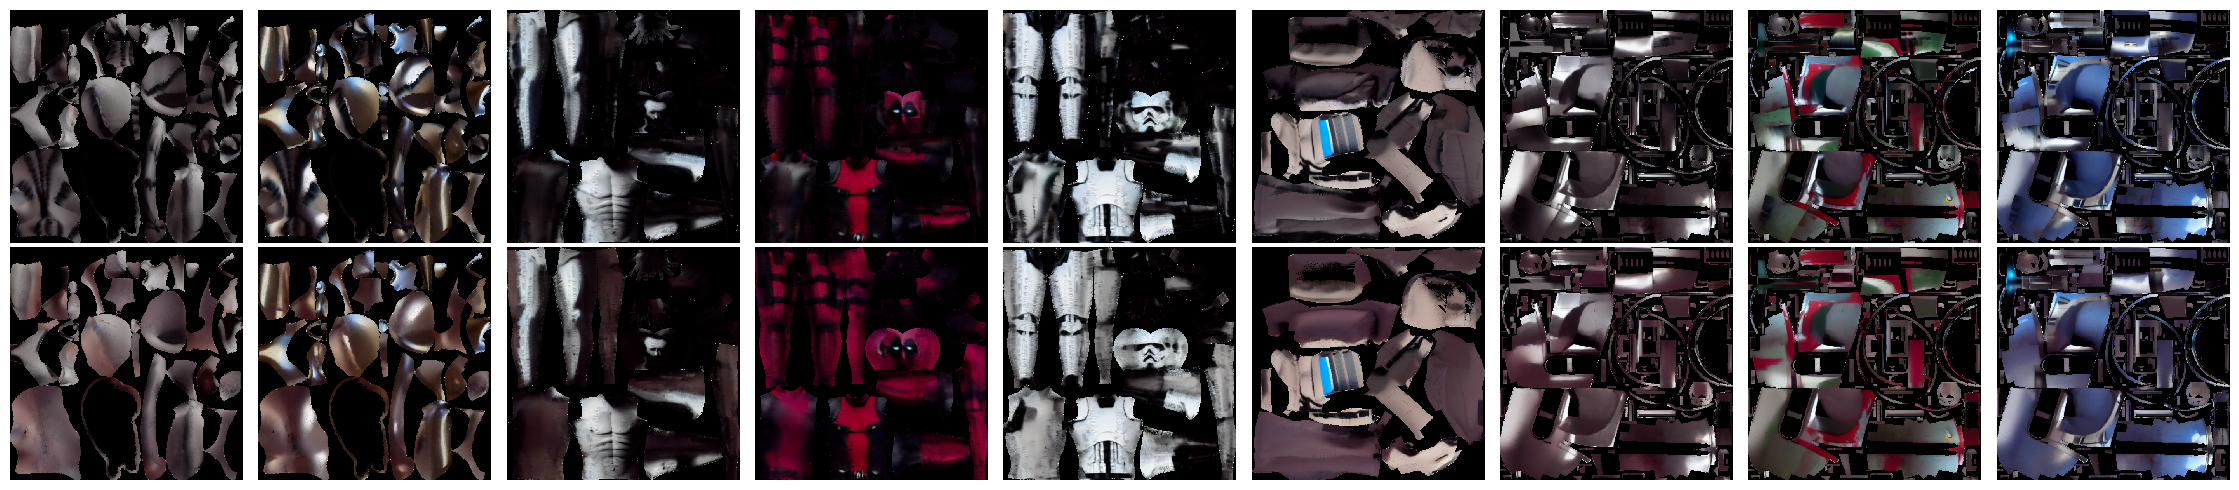

In [148]:
from text3d2video.utilities.ipython_utils import display_ims_grid

textures = map_array(runs_data, lambda r: r.texture_pil)

display_ims_grid(textures)

In [149]:
from text3d2video.utilities.video_comparison import display_vid, video_grid
from text3d2video.utilities.video_util import pil_frames_to_clip


vids = map_array(runs_data, lambda r: pil_frames_to_clip(r.frames, fps=5))
grid = video_grid(vids, y_labels=labels[0])
display_vid(grid)

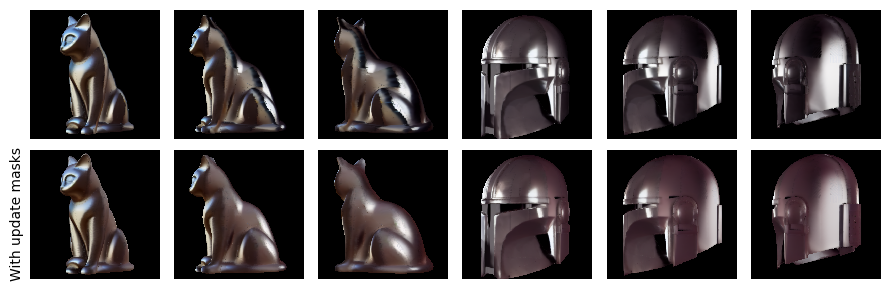

In [152]:
from matplotlib import pyplot as plt
from text3d2video.utilities.attn_vis import concatenate_images
from text3d2video.utilities.ipython_utils import display_ims


frame_indices = [1, 2, 3]

cols = [1, -3]

# for col_i in

image_rows = []

for row in runs_data:
    row_images = []
    for col_i in cols:
        d = row[col_i]
        frames = [d.frames[i] for i in frame_indices]
        row_images.append(frames)

    image_rows.append(concat_lists(row_images))

fig, axs = display_ims_grid(image_rows, row_titles=["", "With update masks"], show=False, scale=1.5)

plt.savefig("outs/with_update_masks.pdf", dpi=300)
